## Part 3 - Predictive Modeling

In [120]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [121]:
# Open and read the JSON file
with open('data/ultimate_data_challenge.json', 'r') as file:
    data = json.load(file)

In [122]:
#Check type of data
type(data)

list

In [123]:
#Convert to df
df_data = pd.DataFrame(data)

In [124]:
df_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [125]:
df_data.shape

(50000, 12)

In [126]:
df_data.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [127]:
df_data['last_trip_date'] = pd.to_datetime(df_data['last_trip_date'])
df_data['signup_date'] = pd.to_datetime(df_data['signup_date'])

In [128]:
df_data.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

### 1. Step one
Cleaning and EDA. What percentage of customers were retained?
What percentage of customers took a trip in the last 30 days?

In [129]:
#Examine missing values
df_data.isnull().sum().sort_values(ascending=False)

avg_rating_of_driver      8122
phone                      396
avg_rating_by_driver       201
city                         0
trips_in_first_30_days       0
signup_date                  0
avg_surge                    0
last_trip_date               0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
dtype: int64

When it comes time to create a pipeline for the model, the ratings features could be imputed with the mean rating for each feature, and the phone feature could be imputed with the mode of that feature.

In [130]:
#What is the latest date?
last_date = df_data.last_trip_date.max()
last_date = pd.to_datetime(last_date)
last_date

Timestamp('2014-07-01 00:00:00')

In [131]:
minus_30 = last_date - pd.Timedelta(days=30)
minus_30

Timestamp('2014-06-01 00:00:00')

In [132]:
#Number of people who took a trip in the last 30 days / total number of customers
last_30 = df_data[df_data['last_trip_date'] >= minus_30]
pct_retained = np.round((last_30.shape[0]/df_data.shape[0])*100, 2)
print(f"{pct_retained}% of customers were retained.")

37.61% of customers were retained.


In [133]:
# Describe
df_data.describe()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,50000,41878.000000,50000.000000,50000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,2014-01-16 13:04:20.352000,4.601559,1.074764,2014-04-19 08:02:04.992000256,8.849536,60.926084,5.796827,4.778158
min,0.000000,2014-01-01 00:00:00,1.000000,1.000000,2014-01-01 00:00:00,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2014-01-09 00:00:00,4.300000,1.000000,2014-02-14 00:00:00,0.000000,33.300000,2.420000,4.700000
50%,1.000000,2014-01-17 00:00:00,4.900000,1.000000,2014-05-08 00:00:00,0.000000,66.700000,3.880000,5.000000
75%,3.000000,2014-01-24 00:00:00,5.000000,1.050000,2014-06-18 00:00:00,8.600000,100.000000,6.940000,5.000000
max,125.000000,2014-01-31 00:00:00,5.000000,8.000000,2014-07-01 00:00:00,100.000000,100.000000,160.960000,5.000000
std,3.792684,NaN,0.617338,0.222336,NaN,19.958811,37.081503,5.707357,0.446652


In [134]:
# Pair plot
#sns.pairplot(df_data)

In [135]:
#Due to some issues with scaling in the pair plot above, individual histograms will be created.
cols = list(df_data.columns)
cols.remove('ultimate_black_user')
#rm = ['signup_date', 'last_trip_date', 'ultimate_black_user']
#cols = [col for col in cols if col not in rm]
cols

['city',
 'trips_in_first_30_days',
 'signup_date',
 'avg_rating_of_driver',
 'avg_surge',
 'last_trip_date',
 'phone',
 'surge_pct',
 'weekday_pct',
 'avg_dist',
 'avg_rating_by_driver']

In [136]:
mode = df_data.phone.mode()[0]
df_temp = df_data.copy()
#df_temp['phone'].fillna(mode, inplace=True)
df_temp['phone'] = df_temp['phone'].fillna(mode)
#plt.hist(df_data['phone'])
unq = df_temp.phone.unique()
unq

array(['iPhone', 'Android'], dtype=object)

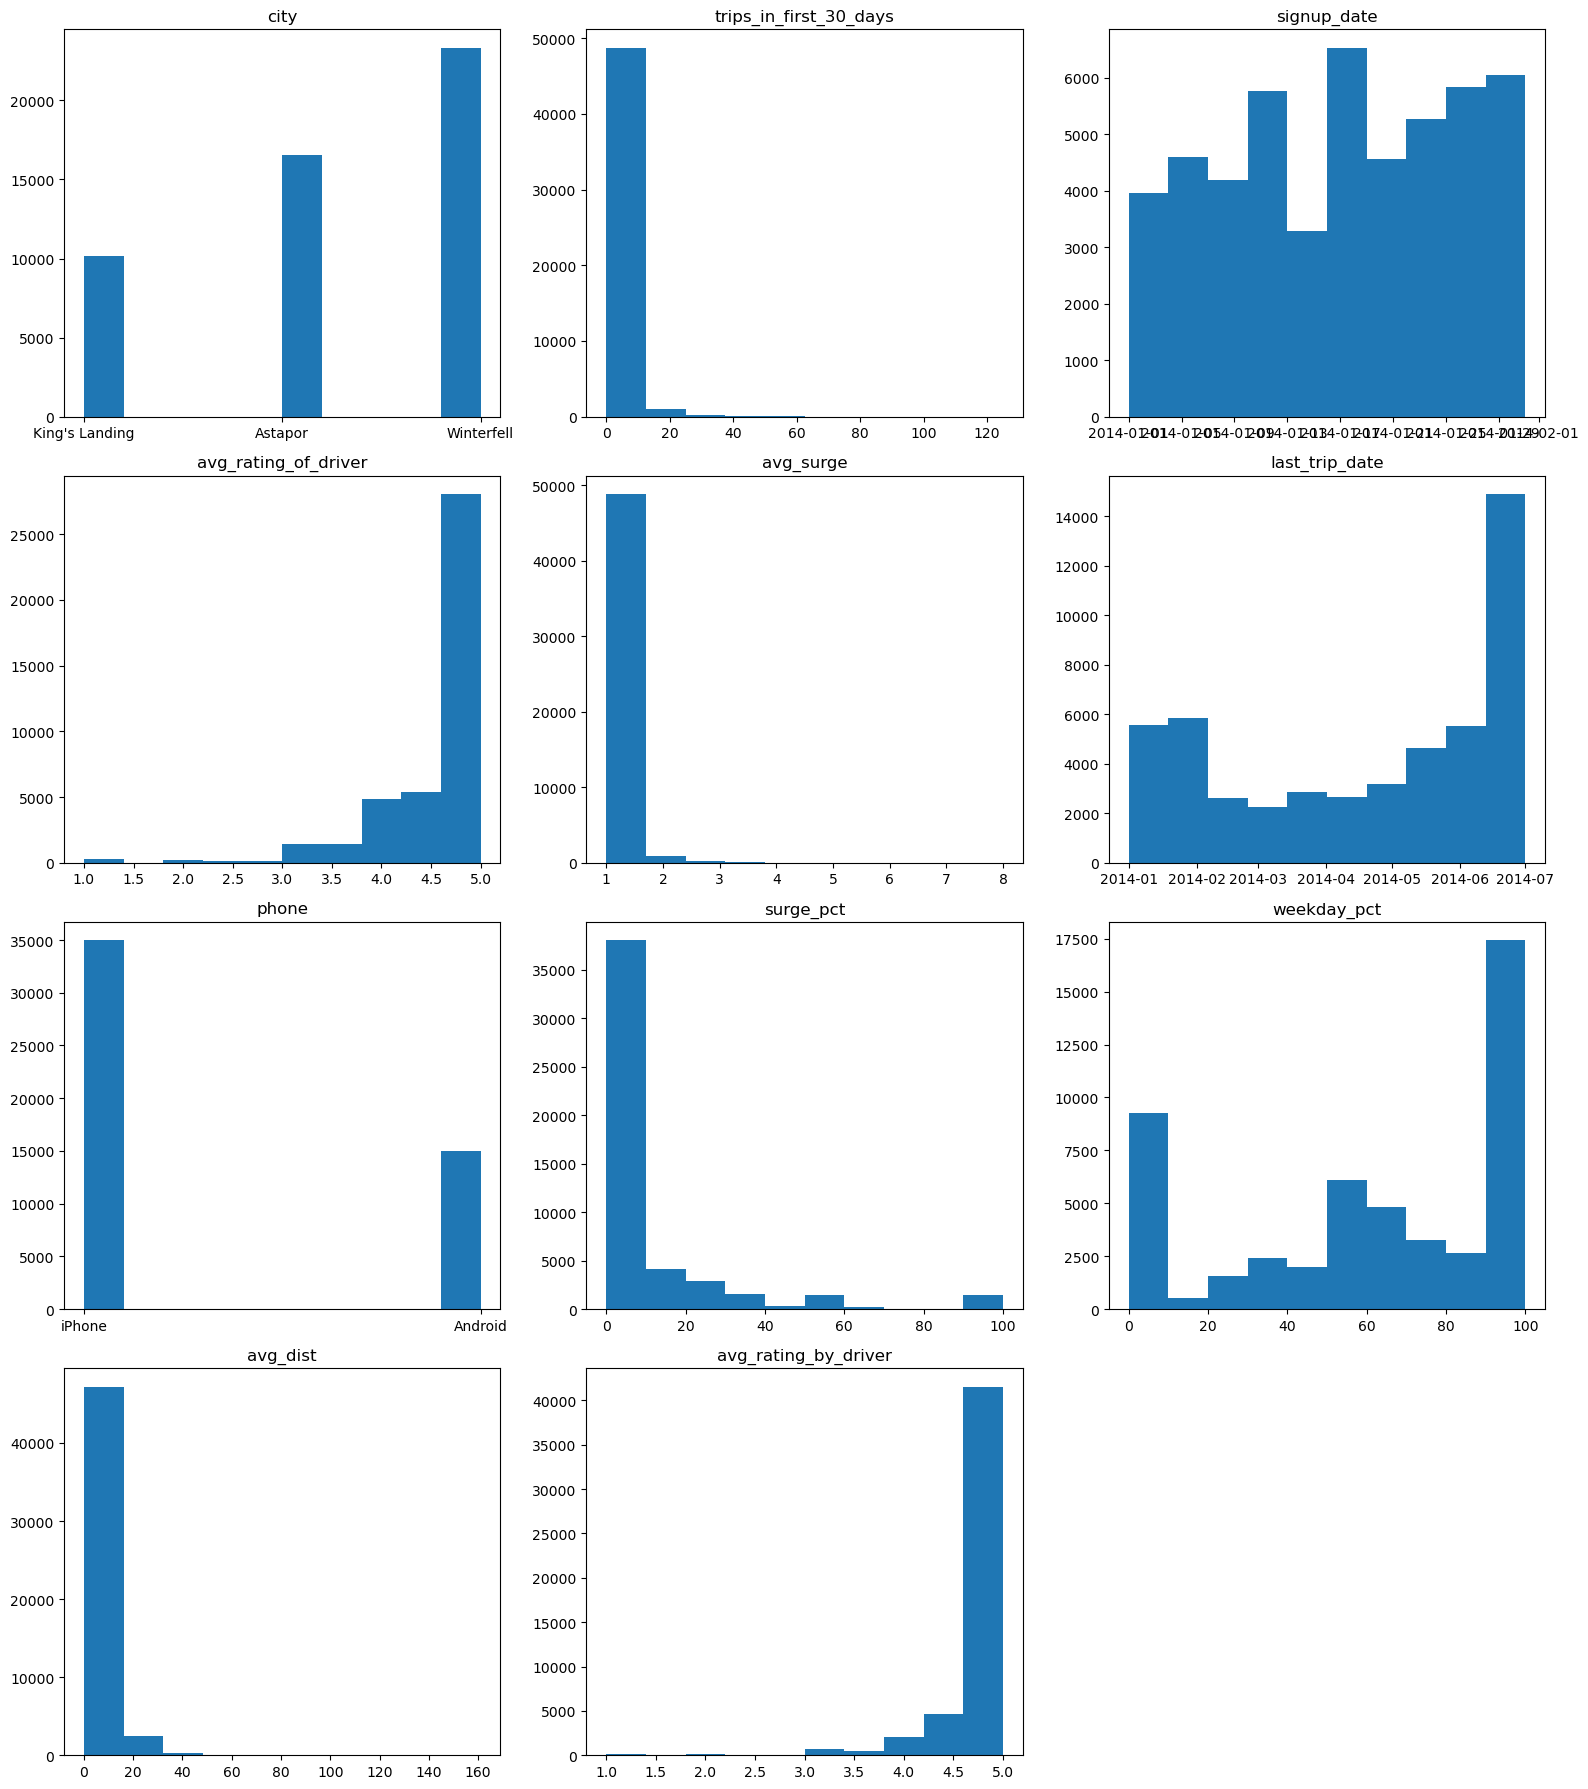

In [137]:
#fig, ax = plt.subplots(3, 4)
#count_i = 0
plt.figure(figsize=(16, 18))
for i in range(len(cols)):
    plt.subplot(4,3,i+1)
    plt.hist(df_temp[cols[i]])
    plt.title(cols[i])
#    sns.histplot(data=df_data, x=cols[count], ax=ax[j])
plt.tight_layout()

C:\Users\keral\anaconda3\envs\london\Lib\site-packages\matplotlib\axes\_axes.py:6862: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


([<matplotlib.axis.XTick at 0x1c2affad340>,
 [Text(0.25, 0, 'False'), Text(0.75, 0, 'True')])

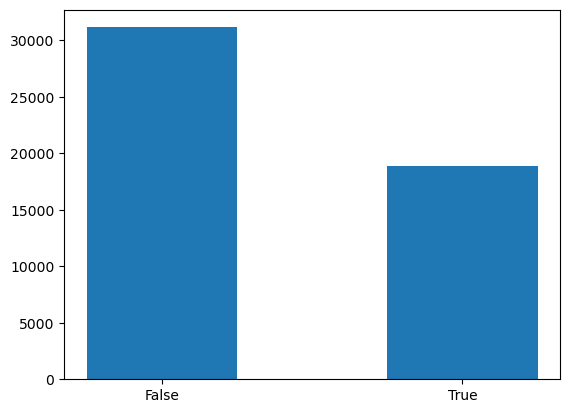

In [138]:
#unq = df_temp.ultimate_black_user.unique()
#unq
#df_temp.ultimate_black_user.dtype
plt.hist(df_temp['ultimate_black_user'],bins=[0, 0.5, 1], align='mid', rwidth=0.5)
plt.xticks([.25, .75], ['False', 'True'])
#df_temp['ultimate_black_user'].value_counts()

(array([16071., 16075., 16079., 16083., 16087., 16091., 16095., 16099.,
        16102.]),
 [Text(16071.0, 0, '2014-01-01'),
  Text(16075.0, 0, '2014-01-05'),
  Text(16079.0, 0, '2014-01-09'),
  Text(16083.0, 0, '2014-01-13'),
  Text(16087.0, 0, '2014-01-17'),
  Text(16091.0, 0, '2014-01-21'),
  Text(16095.0, 0, '2014-01-25'),
  Text(16099.0, 0, '2014-01-29'),
  Text(16102.0, 0, '2014-02-01')])

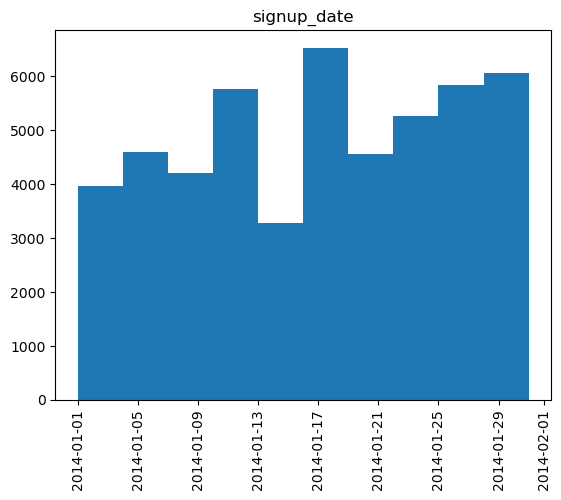

In [139]:
plt.hist(df_temp.signup_date)
plt.title('signup_date')
plt.xticks(rotation=90)

In [140]:
#Encode categorical features (city_name, day_of_week)
df_encode = pd.get_dummies(df_temp)
df_encode.head(20)

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,False,True,False,False,True
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,True,False,False,True,False
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,True,False,False,False,True
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,False,True,False,False,True
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,False,False,True,True,False
5,2,2014-01-09,3.5,1.00,2014-06-06,0.0,True,100.0,10.56,5.0,False,False,True,False,True
6,1,2014-01-24,NaN,1.00,2014-01-25,0.0,False,100.0,3.95,4.0,True,False,False,True,False
7,2,2014-01-28,5.0,1.00,2014-01-29,0.0,False,100.0,2.04,5.0,False,False,True,False,True
8,2,2014-01-21,4.5,1.00,2014-02-01,0.0,False,100.0,4.36,5.0,False,False,True,True,False
9,1,2014-01-03,NaN,1.00,2014-01-05,0.0,False,0.0,2.37,5.0,False,False,True,True,False


<Axes: >

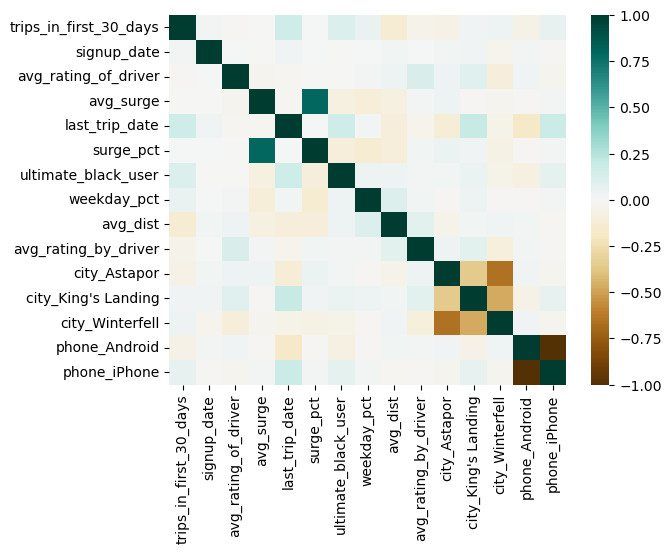

In [141]:
sns.heatmap(df_encode.corr(), cmap='BrBG')

### 2. Step two
Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.

### This is a churn problem.
Given that this is a churn problem, the modeling should be classification modeling. 
A feature "churned" was created by evaluating whether a customer took a trip in June since all sign up dates are in January. 
One issue that the data presents is that all of the sign up dates are in January and the data only extends through July 1st interms of last trip date. One issue is that there may be something about those who sign up in January that affects overall churn rates - e.g. new year's resolutions or cold weather. It would be useful to have data from other months. 
The data of churned v. not churned is somewhat imbalanced although not excessively, with just over 30% of customers not churned. 


In [142]:
df_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [143]:
df_data.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

### Create target feature 'churned'

In [144]:
#All signups were in January, so evaluate how many customers had trips in June
mo_6 = pd.to_datetime("2014-06-01")

#Create a new feature that is a boolean that evaluates whether the last-trip date is within the given window
df_data['churned'] = df_data['last_trip_date'] < mo_6
df_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,churned
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,False
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,True
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,True
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,False
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,True


## Modeling

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_validate, GridSearchCV, learning_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import set_config

### Split the data

In [146]:
X = df_data.drop(columns='churned')
y = df_data.churned
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [147]:
#Create a pipeline that does the following:
#Imputes the ratings columns with the mean
#Imputes the phone column with the mode
#One-hot encodes the city and phone categories
#Scales the data
#Establishes the model

In [148]:
numerical_cols = ['avg_rating_of_driver']
categorical_cols = ['city', 'phone']

set_config(transform_output="pandas")

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [149]:
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [150]:
import timeit
start = timeit.default_timer()
print("The start time is :", start)
pipe.fit(X_train, y_train)
print("The difference of time is :", 
              timeit.default_timer() - start)

The start time is : 316106.2638702
The difference of time is : 1.1364362000022084


In [151]:
y_pred = pipe.predict(X_test)

In [152]:
conf_mat = confusion_matrix(y_test, y_pred)
class_rep = classification_report(y_test, y_pred)
acc_score = accuracy_score(y_test, y_pred)

Text(50.722222222222214, 0.5, 'True label')

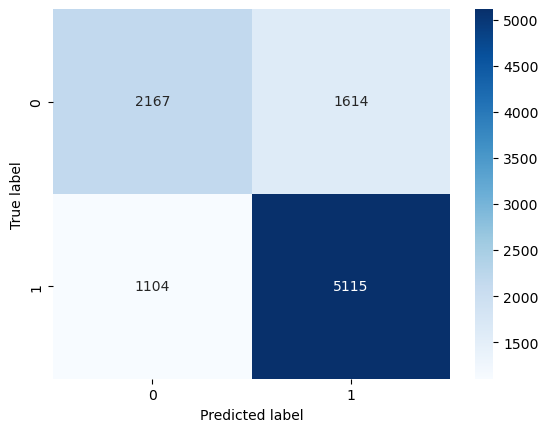

In [153]:
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')

In [154]:
print(class_rep)
print(acc_score)

              precision    recall  f1-score   support

       False       0.66      0.57      0.61      3781
        True       0.76      0.82      0.79      6219

    accuracy                           0.73     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.72      0.73      0.72     10000

0.7282


In [155]:
# retrieving the Classifier from the model pipeline
clf = pipe[-1]
# making a pandas dataframe
data = list(zip(clf.feature_names_in_, clf.feature_importances_))
df_importances = pd.DataFrame(data, columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
df_importances

,Feature,Importance
0,num__avg_rating_of_driver,0.472409
2,cat__city_King's Landing,0.191269
5,cat__phone_iPhone,0.104655
4,cat__phone_Android,0.104262
1,cat__city_Astapor,0.078182
3,cat__city_Winterfell,0.047804
6,cat__phone_None,0.001420


In [156]:
df_importances

,Feature,Importance
0,num__avg_rating_of_driver,0.472409
2,cat__city_King's Landing,0.191269
5,cat__phone_iPhone,0.104655
4,cat__phone_Android,0.104262
1,cat__city_Astapor,0.078182
3,cat__city_Winterfell,0.047804
6,cat__phone_None,0.001420


### Checking for class imbalance

In [157]:
not_churned = df_data.churned[df_data.churned == 0].shape[0]
percent_retained = np.round(not_churned/df_data.shape[0] * 100, 2)
percent_retained

37.61

### Test other models - Logistic Regression

In [158]:
pipe.set_params(model=LogisticRegression())

# Fit the pipeline again with the new classifier
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['avg_rating_of_driver']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['city', 'phone'])])),
                ('scaler', StandardScaler()), ('model', LogisticRegression())])

In [159]:
y_pred = pipe.predict(X_test)

In [160]:
conf_mat = confusion_matrix(y_test, y_pred)
class_rep = classification_report(y_test, y_pred)
acc_score = accuracy_score(y_test, y_pred)

In [161]:
print(conf_mat)
print(class_rep)
print(acc_score)

[[1107 2674]
 [ 476 5743]]
              precision    recall  f1-score   support

       False       0.70      0.29      0.41      3781
        True       0.68      0.92      0.78      6219

    accuracy                           0.69     10000
   macro avg       0.69      0.61      0.60     10000
weighted avg       0.69      0.69      0.64     10000

0.685


In [162]:
# retrieving the Classifier from the model pipeline
clf = pipe[-1]
# making a pandas dataframe
data = list(zip(clf.feature_names_in_, clf.coef_[0]))
df_importances = pd.DataFrame(data, columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
df_importances

,Feature,Importance
1,cat__city_Astapor,0.282962
4,cat__phone_Android,0.261549
3,cat__city_Winterfell,0.058574
0,num__avg_rating_of_driver,0.044157
6,cat__phone_None,-0.016162
5,cat__phone_iPhone,-0.256554
2,cat__city_King's Landing,-0.404860


In [163]:
df_importances['Importance'] = df_importances['Importance'].apply(lambda x: x * -1 if x < 0 else x)
df_importances.sort_values('Importance', inplace=True)
df_importances

,Feature,Importance
6,cat__phone_None,0.016162
0,num__avg_rating_of_driver,0.044157
3,cat__city_Winterfell,0.058574
5,cat__phone_iPhone,0.256554
4,cat__phone_Android,0.261549
1,cat__city_Astapor,0.282962
2,cat__city_King's Landing,0.404860


### Support Vector Machines

In [165]:
pipe.set_params(model=SVC(kernel='linear', random_state=42))

# Fit the pipeline again with the new classifier
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['avg_rating_of_driver']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['city', 'phone'])])),
                ('scaler', StandardScaler()),
                ('model', SVC(kernel='linear', random_state=42))])

In [166]:
y_pred = pipe.predict(X_test)

In [167]:
conf_mat = confusion_matrix(y_test, y_pred)
class_rep = classification_report(y_test, y_pred)
acc_score = accuracy_score(y_test, y_pred)

In [168]:
print(conf_mat)
print(class_rep)
print(acc_score)

[[1308 2473]
 [ 744 5475]]
              precision    recall  f1-score   support

       False       0.64      0.35      0.45      3781
        True       0.69      0.88      0.77      6219

    accuracy                           0.68     10000
   macro avg       0.66      0.61      0.61     10000
weighted avg       0.67      0.68      0.65     10000

0.6783


### Gradient Boosting Classifier

In [170]:
pipe.set_params(model=GradientBoostingClassifier(n_estimators=100, random_state=42))

# Fit the pipeline again with the new classifier
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['avg_rating_of_driver']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['city', 'phone'])])),
                ('scaler', StandardScaler()),
                ('model', GradientBoostingClassifier(random_state=42))])

In [171]:
y_pred = pipe.predict(X_test)

In [172]:
conf_mat = confusion_matrix(y_test, y_pred)
class_rep = classification_report(y_test, y_pred)
acc_score = accuracy_score(y_test, y_pred)

In [173]:
print(conf_mat)
print(class_rep)
print(acc_score)

[[2200 1581]
 [1126 5093]]
              precision    recall  f1-score   support

       False       0.66      0.58      0.62      3781
        True       0.76      0.82      0.79      6219

    accuracy                           0.73     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.72      0.73      0.73     10000

0.7293


In [174]:
# retrieving the Classifier from the model pipeline
clf = pipe[-1]
# making a pandas dataframe
data = list(zip(clf.feature_names_in_, clf.feature_importances_))
df_importances = pd.DataFrame(data, columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
df_importances

,Feature,Importance
0,num__avg_rating_of_driver,0.450850
2,cat__city_King's Landing,0.291173
4,cat__phone_Android,0.151049
5,cat__phone_iPhone,0.054802
1,cat__city_Astapor,0.039852
3,cat__city_Winterfell,0.012002
6,cat__phone_None,0.000272


<BarContainer object of 7 artists>

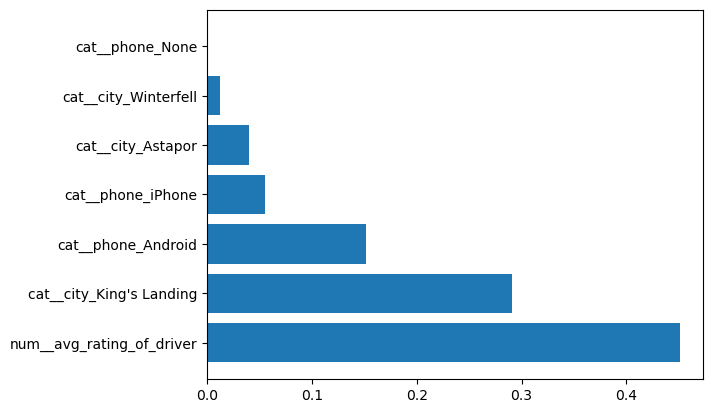

In [176]:
plt.barh(df_importances['Feature'], df_importances['Importance'])

In [181]:
df_data.head()
df_mini = df_data[df_data['churned']==True]
df_mini.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,churned
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,True
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,True
6,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,Android,0.0,False,100.0,3.95,4.0,True
7,Winterfell,2,2014-01-28,5.0,1.00,2014-01-29,iPhone,0.0,False,100.0,2.04,5.0,True


In [182]:
df_mini.describe()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,31196.000000,31196,24706.000000,31196.000000,31196,31196.000000,31196.000000,31196.000000,31031.000000
mean,1.658482,2014-01-16 16:22:08.478009856,4.607557,1.075339,2014-03-12 22:03:51.722015744,8.666739,60.647032,6.207939,4.787464
min,0.000000,2014-01-01 00:00:00,1.000000,1.000000,2014-01-01 00:00:00,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2014-01-10 00:00:00,4.400000,1.000000,2014-01-25 00:00:00,0.000000,16.700000,2.320000,4.800000
50%,1.000000,2014-01-17 00:00:00,5.000000,1.000000,2014-03-09 00:00:00,0.000000,69.600000,4.030000,5.000000
75%,2.000000,2014-01-24 00:00:00,5.000000,1.000000,2014-04-29 00:00:00,0.000000,100.000000,7.800000,5.000000
max,73.000000,2014-01-31 00:00:00,5.000000,8.000000,2014-05-31 00:00:00,100.000000,100.000000,129.890000,5.000000
std,2.654222,NaN,0.664418,0.251361,NaN,22.179139,40.982688,6.238675,0.504648


In [186]:
df_mini.city.value_counts()

city
Winterfell        15123
Astapor           12306
King's Landing     3767
Name: count, dtype: int64

array([[<Axes: title={'center': 'avg_rating_of_driver'}>]], dtype=object)

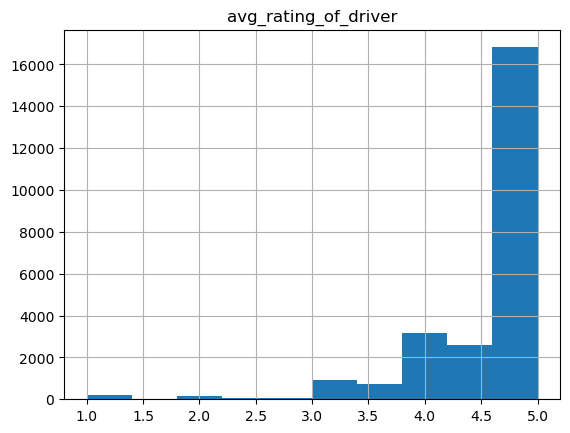

In [189]:
df_mini.hist('avg_rating_of_driver')

In [185]:
df_mini2 = df_data[df_data['churned'] == False]
df_mini2.describe()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,18804.000000,18804,17172.000000,18804.000000,18804,18804.000000,18804.000000,18804.000000,18768.000000
mean,3.306318,2014-01-16 07:36:11.027440640,4.592930,1.073809,2014-06-20 09:46:31.320995584,9.152797,61.389034,5.114788,4.762772
min,0.000000,2014-01-01 00:00:00,1.000000,1.000000,2014-06-01 00:00:00,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2014-01-09 00:00:00,4.300000,1.000000,2014-06-14 00:00:00,0.000000,44.400000,2.560000,4.700000
50%,2.000000,2014-01-17 00:00:00,4.800000,1.000000,2014-06-22 00:00:00,0.000000,64.300000,3.730000,4.800000
75%,4.000000,2014-01-24 00:00:00,5.000000,1.090000,2014-06-28 00:00:00,13.300000,84.600000,5.890000,5.000000
max,125.000000,2014-01-31 00:00:00,5.000000,4.500000,2014-07-01 00:00:00,100.000000,100.000000,160.960000,5.000000
std,4.986743,NaN,0.542386,0.163170,NaN,15.588704,29.487584,4.615175,0.328489


In [187]:
df_mini2.city.value_counts()

city
Winterfell        8213
King's Landing    6363
Astapor           4228
Name: count, dtype: int64

(0.0, 16000.0)

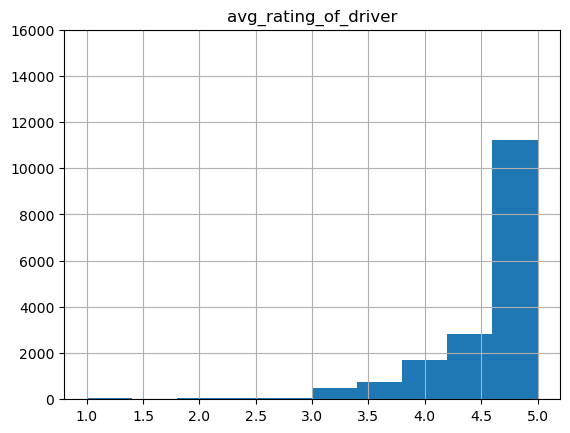

In [192]:
df_mini2.hist('avg_rating_of_driver')
plt.ylim(0, 16000)

### 3. Step three
Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice)

The best performing model is the Gradient Boosting Classifier with an accuracy score of 72.9%. According to that model, the most important features are the average rating of the driver and the city being King's Landing. This seems to indicate that the rating of the driver and the individuals from King's Landing are most likely to churn (although this does not seem to be born out from cursory observations of the data).
Ultimate Tech could try to improve their customer retention by doing two things:
1. Work with drivers that received lower ratings to improve on areas they might be deficient in.
2. Target customers in King's Landing by offering discounts, increasing advertisments or even doing more research into why that city would result in lower satisfactions rates (e.g. does it take longer for vehicles to reach them resulting in longer wait times?).
